source of wiki corpus: https://zenodo.org/record/162792#.X2oUsZMzaWY

In [13]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')
import logging
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


configure project

In [14]:
fname = '158165.txt'
fname2 = '161718.txt'
fpath = '/Users/dunguyen/Dataset/W07_14/PRESS_W07_14/2014-02-10/' + fname

encoding = 'ISO-8859-1'

In [15]:
from src.data.frnewslink import format_assgn_line, get_content
from src.data.frnewslink_dataset import FrNewsLinkDataset

ImportError: cannot import name 'get_content' from 'src.data.frnewslink' (/Users/dunguyen/Projects/frnewslink/src/data/frnewslink.py)

In [ ]:
doc = get_content(fpath, encoding)
if doc is None:
    print('file ' + fpath + ' not found')
else:
    print('Loaded')
    
txt = doc['TEXT']
print('='*30)
print(txt)

## Config project

In [27]:
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models import Word2Vec, KeyedVectors
import numpy as np

import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import spacy
nlp = spacy.load('fr_core_news_md')

In [9]:
tokens = word_tokenize(txt, language='french')
display(tokens[:10])

['Les',
 'Suisses',
 'votent',
 'pour',
 'des',
 'quotas',
 "d'immigration",
 'dimanche',
 '9',
 'février']

In [28]:
doc = nlp(txt)
columns = ['token', 'tag']
df = pd.DataFrame(columns=columns)
i = 0
for t in doc[:40]:
    if t.is_punct or t.is_space:
        continue
    df.loc[t] = [t.lemma_, t.pos_]
    i+=1
    
display(df.transpose())

Les Suisses votent  pour  des quotas   d'  immigration  dimanche    9  \
token   le  suisse  voter  pour   un  quota   de  immigration  dimanche    9   
tag    DET    NOUN   VERB   ADP  DET   NOUN  ADP         NOUN      NOUN  NUM   

       février  2014  22h28  Texte     +  ZURICH  Reuters  Les Suisses    ont  \
token  février  2014  22h28  texte  plus  ZURICH  Reuters   le  suisse  avoir   
tag       NOUN   NUM  PROPN   NOUN   ADP       X    PROPN  DET    NOUN    AUX   

        voté   de  justesse  dimanche   en  faveur   de   la  
token  voter   de  justesse  dimanche   en  faveur   de   le  
tag     VERB  ADP      NOUN      NOUN  ADP    NOUN  ADP  DET

In [8]:
def get_sequence_from_text(text, nlp = spacy.load('fr_core_news_md')):
    """
    @return (seq, embedding)
        :seq: (sequences) list of ID in embedding
        :embedding: matrix of vocab, allow to find out sequences
    """
    
    doc = nlp(text)
    seq = []
    lemmes = []
    for tk in doc:
        if tk.has_vector and (not tk.is_punct) and (not tk.is_space) and (tk.pos_ != 'DET'):
            seq.append(tk.vocab.vectors.find(key = tk.orth))
            lemmes.append(tk.lemma_.lower())
    
    return seq, doc, lemmes

def get_embedding_from_doc_spacy(doc):
    return doc.vocab.vectors.data

seq, doc, lemmes = get_sequence_from_text(txt, nlp)
embedding = get_embedding_from_doc_spacy(doc)

print('30 words in lemmes:', lemmes[:30])
print('================================')
print('length of sequence: ', len(seq))
print('length of lemme: ', len(lemmes))
print('shape of embedding: ', embedding.shape)

30 words in lemmes: ['suisse', 'voter', 'pour', 'quota', 'de', 'immigration', 'dimanche', '9', 'février', '2014', 'texte', 'plus', 'zurich', 'reuters', 'suisse', 'avoir', 'voter', 'de', 'justesse', 'dimanche', 'en', 'faveur', 'de', 'réintroduction', 'de', 'quota', 'de', 'immigration', 'avec', 'union']
length of sequence:  235
length of lemme:  235
shape of embedding:  (20000, 300)


### Search in database

In [37]:
from os import path

# Change this
DATA_ROOT = 'dataset'

# Auto mapping
SOURCE = ['W07_14', 'W05_15']
AN_PRE = 'ANNOT_'
PR_PRE = 'PRESS_'
TV_PRE = 'TV_'

def getfullpath(source:str = 'W07_14'):
    """
    Return annotation_path, press_path, tv_path
    """
    
    annot_dir = path.join(DATA_ROOT, source, AN_PRE + source)
    press_dir = path.join(DATA_ROOT, source, PR_PRE + source)
    tv_dir = path.join(DATA_ROOT, source, TV_PRE + source)
    return annot_dir, press_dir, tv_dir

def content_from_id(press_path:str, id:str, encoding:str):
    return get_document(os.path.join(press_path, id + '.txt'), encoding)

annot_path, press_path, tv_path = getfullpath(SOURCE[0])
print('annot_path: ', annot_path)
print('press_path: ', press_path)
print('tv_path: ', tv_path)

annot_path:  dataset/W07_14/ANNOT_W07_14
press_path:  dataset/W07_14/PRESS_W07_14
tv_path:  dataset/W07_14/TV_W07_14


In [36]:
import os
from src.py_data.frnewlinks import format_assgn_line

In [80]:
# in dev/debug
# investigate the "press" folder
from src.py_data.frnewlinks import get_content
from src.py_data.processing_data import tokenize
import progressbar

src = SOURCE[0]

# To read all files in "press" folder, we have to list all the file, concat the file name
columns = ['filename', 'text length', 'token length']
data = []

pb_widgets = ['Processing ', progressbar.Counter(), ' file(s) ',
               progressbar.Bar('=', '[', ']'), ' (', progressbar.ETA(), ') ', progressbar.AnimatedMarker()]

for sdir in os.listdir(press_path): # Under 'PRES_WXX_XX' has subfolder of dates
    sdpath = path.join(press_path, sdir)
    if path.isdir(sdpath):          # Avoid .DS_Store

        with progressbar.ProgressBar(max_value=len(os.listdir(sdpath)), widgets=pb_widgets) as bar:
            for f in os.listdir(sdpath):   # Data files contained in subfolders

                fpath = path.join(sdpath, f)
                if path.isfile(fpath) and '.txt' in fpath: # Avoid .DS_Store
                    content = get_content(fpath, encoding)
                    tk = tokenize(content, nlp)
                    data.append([f, len(content), len(tk)])
                bar += 1
    

df_press = pd.DataFrame(data, columns=[columns])
df_press.describe()

Processing 2657 file(s) [==================================] (Time:  0:02:16) |
Processing 1800 file(s) [==================================] (Time:  0:01:28) |
Processing 2776 file(s) [==================================] (Time:  0:02:19) |
Processing 1894 file(s) [==================================] (Time:  0:01:32) |
Processing 2858 file(s) [==================================] (Time:  0:02:34) |
Processing 2767 file(s) [==================================] (Time:  0:02:31) |
Processing 2579 file(s) [==================================] (Time:  0:02:21) |


text length  token length
count   17324.000000  17324.000000
mean     2730.400658    397.952147
std      3111.788944    454.787379
min         1.000000      0.000000
25%      1339.000000    192.000000
50%      2145.000000    308.000000
75%      3335.000000    489.000000
max    130116.000000  18640.000000

<AxesSubplot:>

<AxesSubplot:ylabel='Density'>

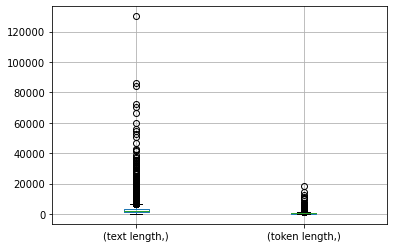

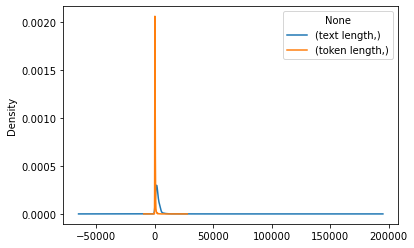

In [85]:
display(df_press.boxplot())
display(df_press.plot.kde())

In [35]:
# in dev/debug
# investigate the annotation folder

for f in os.listdir(annot_path):
    fpath = path.join(annot_path, f)
    if path.isfile(fpath):
        try:
            name, ext = f.split('.')
            
            # files .trs is not interested
            if ext == 'trs':
                continue
                
            fread = open(fpath, 'r')
            line = fread.readline()
            beg_seg, end_seg, id_yes, id_maybe, id_no = format_assgn_line(line)
            break
            
        except ValueError:
            print('File', f, 'cannot be splitted into 2 pieces.')

assgn_dict = dict()

Testing code, read **ONE** single line in an annotation files.
Using function `format_assgn_line()` in order to format into info we need.

In [81]:
files = [f for f in os.listdir(annot_path)]
f = files[1]
fpath = path.join(annot_path, f)
with open(fpath, 'r') as fread:
    line = fread.readline()
    beg_seg, end_seg, id_yes, id_maybe, id_no = format_assgn_line(line)

From `yes_combinations` and `no_combinations` make a dictionary of labels.

In [82]:
# bind all element from two list 
from itertools import product

label_dict = dict()
yes_combinations = [(x, y) for x, y in product(id_yes, id_yes) if x != y]
no_combinations = [(x, y) for x, y in product(id_no, id_no) if x != y]
for k in yes_combinations:
    label_dict[k] = 1.
for k in no_combinations:
    label_dict[k] = 0.

1. List all possible subdir, store it in `press_subdir_paths`.

1. Construct `mapping_file_sudir`. It will map in each sub directory the first id and last id. This helps faster searching subdir for given id of an article.
Format: 
```
{subdir_name: [s_id, e_id]}
```
-- Example: 
```
{'dataset/W07_14/PRESS_W07_14/2014-02-11': [161744, 165137],
 'dataset/W07_14/PRESS_W07_14/2014-02-16': [177426, 179686],
 ...}
```

In [96]:
press_dict = dict()
press_subdir_paths = [path.join(press_path,d) for d in os.listdir(press_path) if path.isdir(path.join(press_path,d))]

""" Construct mapping_file_sudir
"""

mapping_file_subdir = dict()
for sd_path in press_subdir_paths:
    id_files = [f[:-4] for f in os.listdir(sd_path) if path.isfile(path.join(sd_path, f)) and '.txt' in f]
    id_files = list(map(int, id_files))
    mapping_file_subdir[sd_path] = [min(id_files), max(id_files)]

Read content of an article from its `id_article`, given mapping_file_subdir

In [119]:
def get_article_content(id_article, mapping_file_subdir, encoding='ISO-8859-1'):
    
    # 1. Search containing directory (date)
    for dir_path, min_max in mapping_file_subdir.items():
        
        id_min, id_max = min_max
        
        if id_min < id_article < id_max:
            
            article_path = path.join(dir_path, f"{id_article}.txt")
            return get_content(article_path, encoding)
        
    else:
        return None
        
get_article_content(169763, mapping_file_subdir, encoding)

'\nInondations. Avec la Vendée, cinq départements placés en alerte orange\nFrance -\n- 4\nL\'eau est remontée à Malestroit.\xa0|\xa0Photo Thierry Creux / Ouest-France\nIl y avait un mètre d\'eau sur le quai Brizeux à Quimperlé ce jeudi matin.\xa0|\xa0Photo Béatrice Le Grand / Ouest-France.\nAlerte, mercredi après-midi, sur les bords du Blavet à Pontivy (Morbihan), repassé en vigilance orange après l\'accalmie de mardi.\xa0|\xa0Photo : Ouest-France\nAchetez votre journal numérique\nAvec le Finistère, le Morbihan, l\'Ille-et-Vilaine et la Loire-Atlantique, la Vendée est désormais également en alerte orange pour les crues.\nAprès les pluies de la veille, de nouvelles précipitations avec risque d\'orage et de grêle ont sont tombées sur l\'Ouest ce jeudi.\nLes pluies sont actuellement en train de se calmer, avant l\'arrivée d\'une nouvelle tempête, vendredi, où des vents jusqu\'à 130 km/h sont attendus sur les caps les plus exposés en soirée.\nLire aussi\nLog in or register to post comments

## Testing model

In [167]:
from torch.nn.utils.rnn import pad_sequence

labels = {
    (169763, 171661): 1.0,
    (170804, 171918): 0.0
}

x1 = []
x2 = []
y = []

for id1, id2 in labels:
    content = get_article_content(id1, mapping_file_subdir, encoding)
    seq, _, _ = get_sequence_from_text(content)
    x1.append(seq)
    content = get_article_content(id2, mapping_file_subdir, encoding)
    tokens = tokenize(content)
    x2.append(tokens)
    y.append(labels.get((id1, id2)))
    
pad_sequence(x1)
pad_sequence(x2)

AttributeError: 'list' object has no attribute 'size'

## Load from **SNLI** dataset

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('src')
from IPython.display import display

In [2]:
from src.data.snli import load_labels
import pandas as pd
from tqdm import tqdm
import json

In [3]:
save_path = 'src/_out/labels/snli_train.csv'
labels = pd.read_csv(save_path)

In [18]:
lenc = {
    'contradiction': 0,
    'entailment': 1,
    'neutral': 2,
}

data_path = '/Users/dunguyen/Dataset/snli/snli_1.0_train.jsonl'
with open(data_path, 'r') as json_file:
    json_list = list(json_file)
    
label_dict = {'sentence1': list(), 'sentence2': list(), 'gold_label': list()}

for json_str in tqdm(json_list, desc=f'Load SNLI '):
    line = json.loads(json_str)
    for k in label_dict.keys():
        label_dict[k].append(line[k])

labels = pd.DataFrame(label_dict)
labels = labels.replace({'gold_label': lenc})

Load SNLI : 100%|██████████| 550152/550152 [00:03<00:00, 176895.26it/s]


In [19]:
from IPython.display import display

In [20]:
display(len(labels))
labels = labels[~labels['gold_label'].isin(['-', 'N/A'])]
labels = labels[~labels['sentence1'].isin(['N/A'])]
labels = labels[~labels['sentence2'].isin(['N/A'])]
display(len(labels))

550152

549364

In [17]:
for text in tqdm(pd.concat([labels['sentence1'], labels['sentence2']]), desc='Building vocab', unit='sentence', file=sys.stdout):
    text = text.replace('-\n', '')

Building vocab: 100%|██████████| 1100304/1100304 [00:00<00:00, 2388548.17sentence/s]


In [7]:
json_list[91381]

'{"annotator_labels": ["neutral"], "captionID": "2896180326.jpg#0", "gold_label": "neutral", "pairID": "2896180326.jpg#0r1n", "sentence1": "A group of people are sitting on dirt bikes in a grassy field.", "sentence1_binary_parse": "( ( ( A group ) ( of people ) ) ( ( are ( sitting ( on ( ( dirt bikes ) ( in ( a ( grassy field ) ) ) ) ) ) ) . ) )", "sentence1_parse": "(ROOT (S (NP (NP (DT A) (NN group)) (PP (IN of) (NP (NNS people)))) (VP (VBP are) (VP (VBG sitting) (PP (IN on) (NP (NP (NN dirt) (NNS bikes)) (PP (IN in) (NP (DT a) (JJ grassy) (NN field))))))) (. .)))", "sentence2": "The people are about to race.", "sentence2_binary_parse": "( ( The people ) ( ( are ( about ( to race ) ) ) . ) )", "sentence2_parse": "(ROOT (S (NP (DT The) (NNS people)) (VP (VBP are) (ADJP (IN about) (PP (TO to) (NP (NN race))))) (. .)))"}\n'

In [6]:
line = json.loads(json_list[91479])
line

{'annotator_labels': ['neutral'],
 'captionID': '7638876050.jpg#4',
 'gold_label': 'neutral',
 'pairID': '7638876050.jpg#4r2n',
 'sentence1': 'Cannot see picture to describe.',
 'sentence1_binary_parse': '( ( ( Can not ) ( ( see picture ) ( to describe ) ) ) . )',
 'sentence1_parse': '(ROOT (S (VP (MD Can) (RB not) (VP (VB see) (NP (NN picture)) (S (VP (TO to) (VP (VB describe)))))) (. .)))',
 'sentence2': 'N/A',
 'sentence2_binary_parse': 'N/A',
 'sentence2_parse': '(ROOT (INTJ (UH N/A)))'}

In [12]:
labels.iloc[91479]

sentence1     Cannot see picture to describe.
sentence2                                 N/A
gold_label                                  2
Name: 91479, dtype: object

In [9]:
labels[labels['sentence1'] == 'Cannot see picture to describe.']

sentence1  \
71739   Cannot see picture to describe.   
71740   Cannot see picture to describe.   
71741   Cannot see picture to describe.   
91479   Cannot see picture to describe.   
91480   Cannot see picture to describe.   
91481   Cannot see picture to describe.   
413322  Cannot see picture to describe.   
413323  Cannot see picture to describe.   
413324  Cannot see picture to describe.   
494247  Cannot see picture to describe.   
494248  Cannot see picture to describe.   
494249  Cannot see picture to describe.   

                                                sentence2 gold_label  
71739    The picture was taken down due to adult content.          2  
71740                  I can see the picture to describe.          0  
71741                              No picture to describe          1  
91479                                                 N/A          2  
91480                                                 N/A          1  
91481                                                 N/A          0  
413322                   The picture cannot be described.          1  
413323                             The picture is blurry.          2  
413324        The picture is crystal clear and beautiful.          0  
494247  There is a dog running in the very clear picture.          0  
494248       There is a picture that cannot be displayed.          1  
494249  The picture was in a fire and now it cannot be...          2

In [13]:
labels.iloc[91479]

sentence1     Cannot see picture to describe.
sentence2                                 N/A
gold_label                                  2
Name: 91479, dtype: object

In [14]:
labels.iloc[91479]['sentence2']

'N/A'